Author: Marco Pellegrino\
Year: 2024

With this notebook, the page language and days of the week impact are analyzed.

In [1]:
from pathlib import Path
import datetime
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from google.cloud import bigquery
import db_dtypes

# Import Dataset

#### a) From locally stored CSV dataset

In [2]:
df = pd.read_csv('../data/raw/train_1.csv', index_col=None)
df.columns = map(str.lower, df.columns) # make column names lowercase

In [3]:
# Melt the DataFrame to a long format
df = df.melt(id_vars=['page'], var_name='date', value_name='traffic')

#### b) From BigQuery

If running directly on GCP

In [4]:
%%bigquery df
SELECT
  page,
  date,
  traffic
FROM
  web_traffic_dataset.web_traffic_tb

UsageError: Cell magic `%%bigquery` not found.


Otherwise, if running locally

In [5]:
# Initialize a BigQuery client
project_id = 'web-traffic-time-series'

client = bigquery.Client(project=project_id)

# Define your query
query = """
SELECT
  page,
  date,
  traffic
FROM
  web_traffic_dataset.web_traffic_tb
"""

df = client.query(query).to_dataframe()

## First Inspection

In [6]:
df["date"] = pd.to_datetime(df["date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79784650 entries, 0 to 79784649
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   page     object        
 1   date     datetime64[ns]
 2   traffic  Int64         
dtypes: Int64(1), datetime64[ns](1), object(1)
memory usage: 1.9+ GB


In [8]:
df.sample(5)

,page,date,traffic
22372646,Marjory_Gordon_es.wikipedia.org_desktop_all-ag...,2016-01-12,60
30894104,東京喰種角色列表_zh.wikipedia.org_all-access_all-agents,2015-08-13,856
25771260,Aurélie_Dupont_fr.wikipedia.org_desktop_all-ag...,2015-09-04,82
76004370,Laura_Siegemund_de.wikipedia.org_mobile-web_al...,2016-11-09,5
13863055,"Александрова,_Марина_Андреевна_ru.wikipedia.or...",2015-07-24,284


# Missing Values

Since the data source for this dataset does not distinguish between traffic values of zero and missing values (a missing value may mean the traffic was zero or that the data is not available for that day), for simplicity missing values are replaced with a null traffic. Another solution can be linear interpolation.

In [9]:
df = df.fillna(0)

# Language Analysis

**Extract the page language**

In [10]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res[0][0:2]
    return 'NA'

df['language'] = df.page.map(get_language)

In [11]:
df.sample(3)

,page,date,traffic,language
65838785,西游·降魔篇_zh.wikipedia.org_desktop_all-agents,2016-11-24,261,zh
73771578,ID4星際重生_zh.wikipedia.org_all-access_all-agents,2015-10-14,0,zh
7400892,Real_Madrid_Club_de_Fútbol_fr.wikipedia.org_al...,2016-08-12,27,fr


**Number of Pages per Language**

In [12]:
df_language_npages = df.groupby('language')['traffic'].agg('count').reset_index()

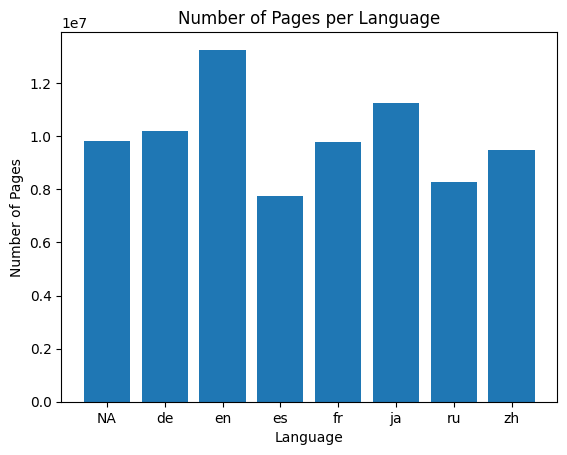

In [13]:
# Sort the DataFrame by language alphabetically
df_language_npages = df_language_npages.sort_values('language')

# Create the bar plot
plt.bar(df_language_npages['language'], df_language_npages['traffic'])
plt.xlabel('Language')
plt.ylabel('Number of Pages')
plt.title('Number of Pages per Language')

plt.show()

In [49]:
df_language_npages

,language,traffic
0,NA,9820250
1,de,10200850
2,en,13259400
3,es,7737950
4,fr,9791100
5,ja,11237050
6,ru,8262100
7,zh,9475950


**Average Language Traffic**

In [14]:
df_language_avg_traffic = df.groupby('language')['traffic'].agg('mean').reset_index()

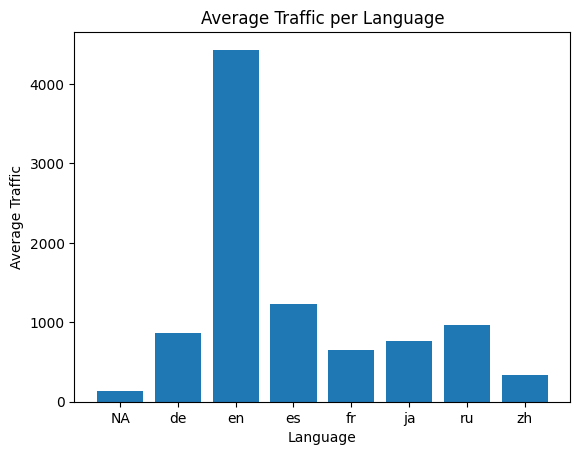

In [15]:
# Sort the DataFrame by language alphabetically
df_language_avg_traffic = df_language_avg_traffic.sort_values('language')

# Create the bar plot
plt.bar(df_language_avg_traffic['language'], df_language_avg_traffic['traffic'])
plt.xlabel('Language')
plt.ylabel('Average Traffic')
plt.title('Average Traffic per Language')
plt.show()

**Total Language Traffic**

In [16]:
df_language_total_traffic = df.groupby('language')['traffic'].agg('sum').reset_index()

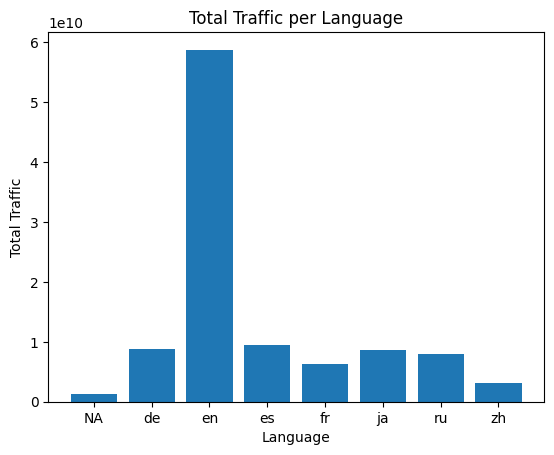

In [17]:
# Sort the DataFrame by language alphabetically
df_language_total_traffic = df_language_total_traffic.sort_values('language')

# Create the bar plot
plt.bar(df_language_total_traffic['language'], df_language_total_traffic['traffic'])
plt.xlabel('Language')
plt.ylabel('Total Traffic')
plt.title('Total Traffic per Language')
plt.show()

**Language Time Series**

In [18]:
df_language_tot_traffic = df.groupby(['date', 'language'])['traffic'].sum().unstack()

Plot language time series

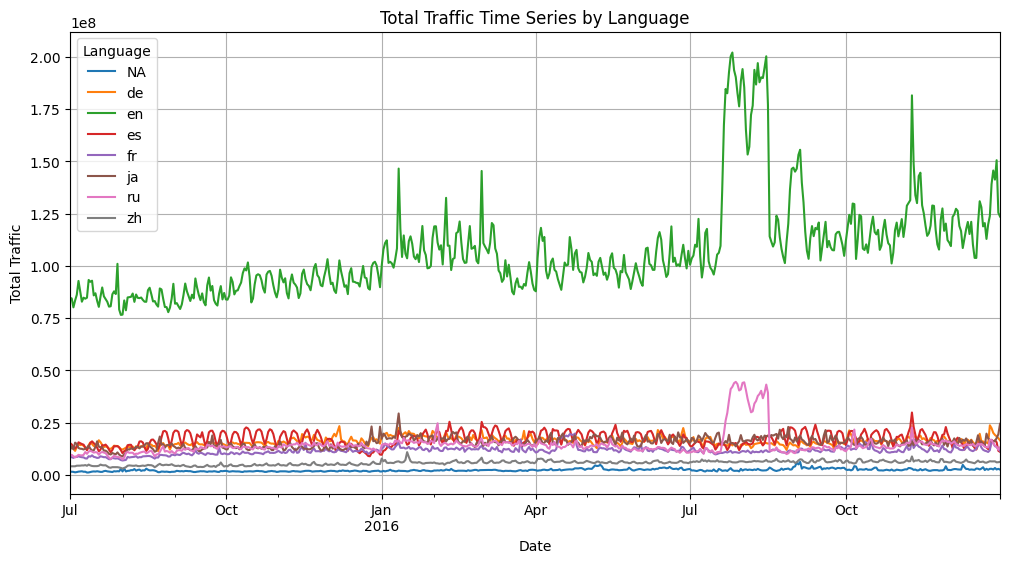

In [19]:
df_language_tot_traffic.plot(figsize=(12, 6))
plt.title('Total Traffic Time Series by Language')
plt.xlabel('Date')
plt.ylabel('Total Traffic')
plt.legend(title='Language')
plt.grid(True)
plt.show()

Insights:
- Traffic of English-based pages is considerably larger than in other languages
- English and Russian demand showed very large spikes around August 2016
  - Maybe due to the Summer Olympics and the election in the US

### Weekday Analysis

In [21]:
# Extract day of the week
df['day_of_week'] = df['date'].dt.day_name()
df['day_of_week_index'] = df['date'].dt.weekday + 1

**Total Traffic per Day**

In [32]:
df_day_total_traffic = df.groupby(['day_of_week', 'day_of_week_index'])['traffic'].agg('sum').reset_index()

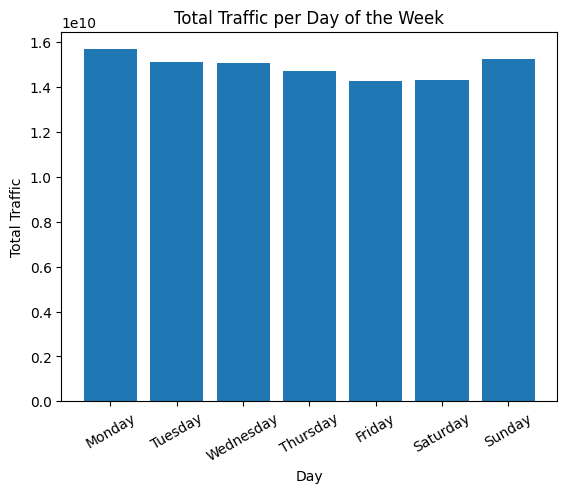

In [35]:
# Sort the DataFrame by day
df_day_total_traffic = df_day_total_traffic.sort_values('day_of_week_index')

# Create the bar plot
plt.bar(df_day_total_traffic['day_of_week'], df_day_total_traffic['traffic'])
plt.xlabel('Day')
plt.ylabel('Total Traffic')
plt.title('Total Traffic per Day of the Week')
plt.xticks(rotation=30)
plt.show()

**Average Traffic per Day**

In [36]:
df_day_avg_traffic = df.groupby(['day_of_week', 'day_of_week_index'])['traffic'].agg('mean').reset_index()

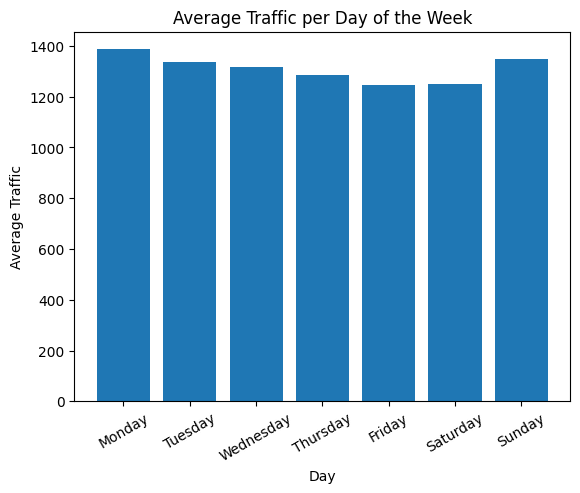

In [37]:
# Sort the DataFrame by day
df_day_avg_traffic = df_day_avg_traffic.sort_values('day_of_week_index')

# Create the bar plot
plt.bar(df_day_avg_traffic['day_of_week'], df_day_avg_traffic['traffic'])
plt.xlabel('Day')
plt.ylabel('Average Traffic')
plt.title('Average Traffic per Day of the Week')
plt.xticks(rotation=30)
plt.show()

Insights:
- More views on Monday and Sunday

# Months Analysis

In [39]:
df['month'] = df['date'].dt.month_name()
df['month_index'] = df['date'].dt.month 

**Total Traffic per Month**

In [40]:
df_month_total_traffic = df.groupby(['month', 'month_index'])['traffic'].agg('sum').reset_index()

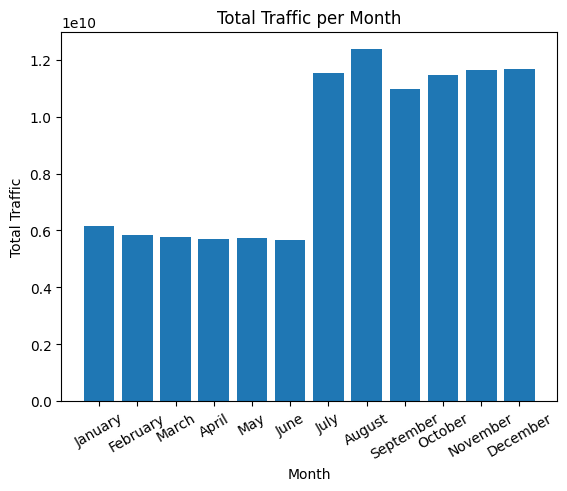

In [43]:
# Sort the DataFrame by month
df_month_total_traffic = df_month_total_traffic.sort_values('month_index')

# Create the bar plot
plt.bar(df_month_total_traffic['month'], df_month_total_traffic['traffic'])
plt.xlabel('Month')
plt.ylabel('Total Traffic')
plt.title('Total Traffic per Month')
plt.xticks(rotation=30)
plt.show()

**Average Traffic per Month**

In [44]:
df_month_avg_traffic = df.groupby(['month', 'month_index'])['traffic'].agg('mean').reset_index()

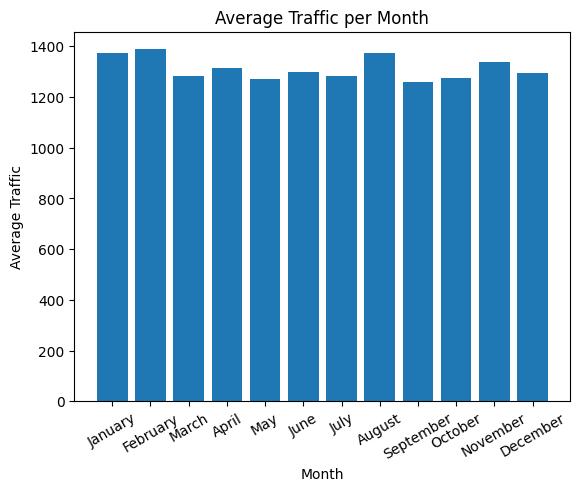

In [48]:
# Sort the DataFrame by month
df_month_avg_traffic = df_month_avg_traffic.sort_values('month_index')

# Create the bar plot
plt.bar(df_month_avg_traffic['month'], df_month_avg_traffic['traffic'])
plt.xlabel('Month')
plt.ylabel('Average Traffic')
plt.title('Average Traffic per Month')
plt.xticks(rotation=30)
plt.show()

Insights:
- Less during the warmer months, but peak in August due to elections and sports

In [50]:
# Save
Path("../data/processed").mkdir(parents=True, exist_ok=True)
df.to_csv('../data/processed/train_1_processed.csv', index=False)